**Objective**: Develop an advanced, interactive recommendation system for cosmetic products based on ingredient similarity, tailored for various skin types and user preferences.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category10
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
sns.set(style="whitegrid")


In [ ]:
df = pd.read_csv('/content/cosmetics.csv')

In [ ]:
print(df.head())
print(df.info())
print(df['Label'].value_counts())
print(df.columns)

         Label           Brand                                           Name  \
0  Moisturizer          LA MER                                Crème de la Mer   
1  Moisturizer           SK-II                       Facial Treatment Essence   
2  Moisturizer  DRUNK ELEPHANT                     Protini™ Polypeptide Cream   
3  Moisturizer          LA MER                    The Moisturizing Soft Cream   
4  Moisturizer    IT COSMETICS  Your Skin But Better™ CC+™ Cream with SPF 50+   

   Price  Rank                                        Ingredients  \
0    175   4.1  Algae (Seaweed) Extract, Mineral Oil, Petrolat...   
1    179   4.1  Galactomyces Ferment Filtrate (Pitera), Butyle...   
2     68   4.4  Water, Dicaprylyl Carbonate, Glycerin, Ceteary...   
3    175   3.8  Algae (Seaweed) Extract, Cyclopentasiloxane, P...   
4     38   4.1  Water, Snail Secretion Filtrate, Phenyl Trimet...   

   Combination  Dry  Normal  Oily  Sensitive  
0            1    1       1     1          1  
1   

In [ ]:
df.describe()

,Price,Rank,Combination,Dry,Normal,Oily,Sensitive
count,1472.000000,1472.000000,1472.00000,1472.000000,1472.000000,1472.000000,1472.000000
mean,55.584239,4.153261,0.65625,0.614130,0.652174,0.607337,0.513587
std,45.014429,0.633918,0.47512,0.486965,0.476442,0.488509,0.499985
min,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,4.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,42.500000,4.300000,1.00000,1.000000,1.000000,1.000000,1.000000
75%,68.000000,4.500000,1.00000,1.000000,1.000000,1.000000,1.000000
max,370.000000,5.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [ ]:
print(df.isnull().sum())
df['Price'].fillna(df['Price'].median(), inplace=True)
df['Rank'].fillna(df['Rank'].mode()[0], inplace=True)
df.dropna(subset=['Ingredients'], inplace=True)
df.drop_duplicates(inplace=True)

Label          0
Brand          0
Name           0
Price          0
Rank           0
Ingredients    0
Combination    0
Dry            0
Normal         0
Oily           0
Sensitive      0
dtype: int64


In [ ]:
df['Price'] = df['Price'].astype(float)

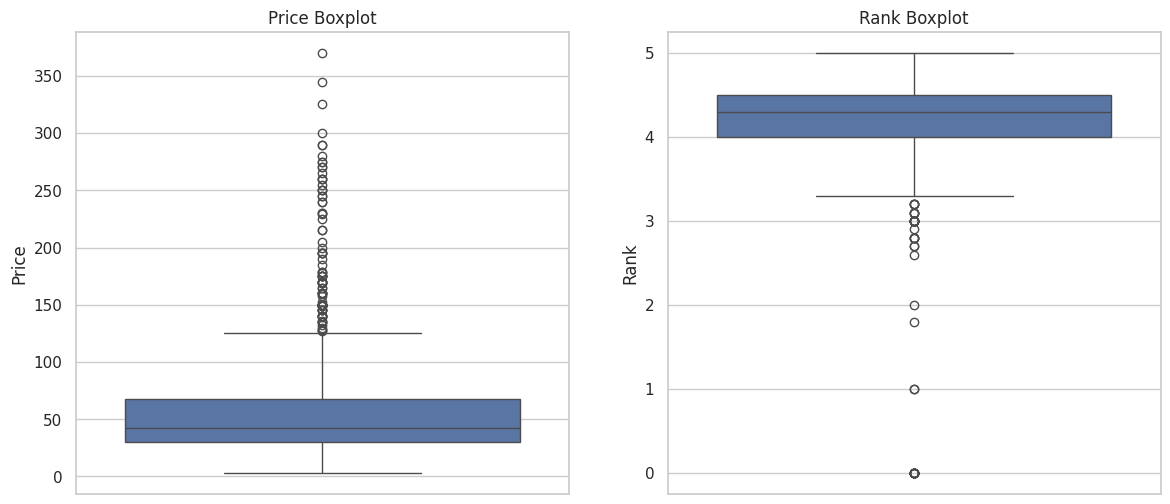

In [ ]:
plt.figure(figsize=(14, 6))

# Boxplot for Price
plt.subplot(1, 2, 1)
sns.boxplot(df['Price'])
plt.title('Price Boxplot')

# Boxplot for Rank
plt.subplot(1, 2, 2)
sns.boxplot(df['Rank'])
plt.title('Rank Boxplot')

plt.show()




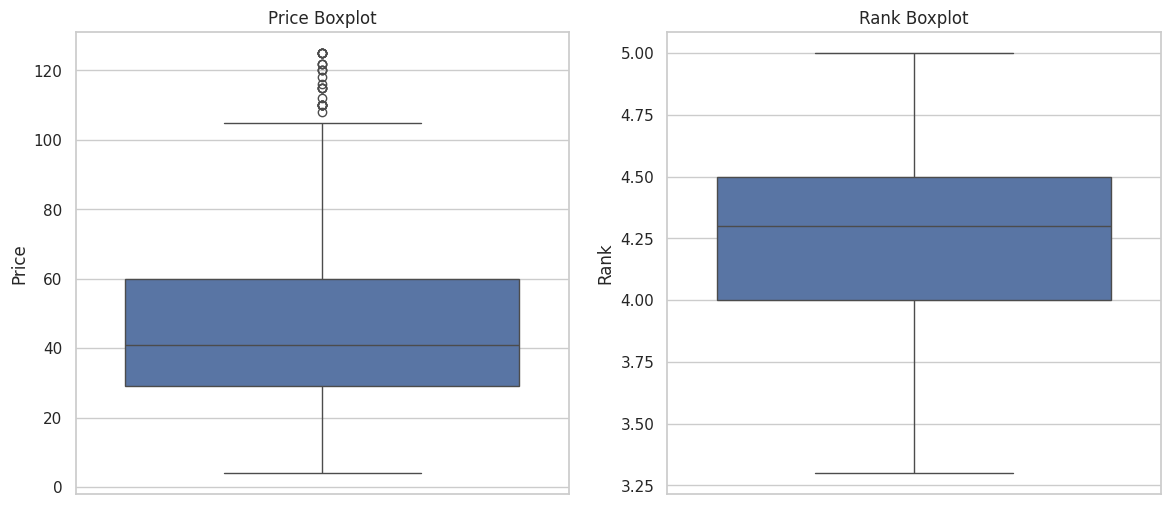

In [ ]:
Q1_price = df['Price'].quantile(0.25)
Q3_price = df['Price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
outlier_threshold_low_price = Q1_price - 1.5 * IQR_price
outlier_threshold_high_price = Q3_price + 1.5 * IQR_price

df = df[(df['Price'] >= outlier_threshold_low_price) & (df['Price'] <= outlier_threshold_high_price)]

Q1_rank = df['Rank'].quantile(0.25)
Q3_rank = df['Rank'].quantile(0.75)
IQR_rank = Q3_rank - Q1_rank
outlier_threshold_low_rank = Q1_rank - 1.5 * IQR_rank
outlier_threshold_high_rank = Q3_rank + 1.5 * IQR_rank

df = df[(df['Rank'] >= outlier_threshold_low_rank) & (df['Rank'] <= outlier_threshold_high_rank)]

plt.figure(figsize=(14, 6))

# Boxplot for Price
plt.subplot(1, 2, 1)
sns.boxplot(df['Price'])
plt.title('Price Boxplot')

# Bxplot for Rank
plt.subplot(1, 2, 2)
sns.boxplot(df['Rank'])
plt.title('Rank Boxplot')

plt.show()


In [ ]:
product_categories = ['Moisturizer', 'Cleanser', 'Treatment', 'Face Mask', 'Eye cream', 'Sun protect']
skin_types = ['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive']

def filter_data(df, product_categories, skin_types):
    filtered_df = df[df['Label'].isin(product_categories)]
    filtered_df = filtered_df[filtered_df[['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive']].isin([1]).any(axis=1)]
    filtered_df = filtered_df.reset_index(drop=True)
    return filtered_df

filtered_df = filter_data(df, product_categories, skin_types)


In [ ]:
def tokenize_ingredients(df):
    df['Ingredients'] = df['Ingredients'].str.lower().str.replace(', ', ' ')
    return df['Ingredients']

ingredients_text = tokenize_ingredients(filtered_df)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(ingredients_text)

In [ ]:
svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_svd)

In [ ]:
tsne_model = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_features = tsne_model.fit_transform(X_scaled)

tsne_df = pd.DataFrame(tsne_features, columns=['X', 'Y'])
tsne_df['Label'] = filtered_df['Label']
tsne_df['Name'] = filtered_df['Name']
tsne_df['Brand'] = filtered_df['Brand']
tsne_df['Price'] = filtered_df['Price']
tsne_df['Rank'] = filtered_df['Rank']
tsne_df['Ingredients'] = filtered_df['Ingredients']


In [ ]:
fig = px.scatter(tsne_df, x='X', y='Y', color='Label', hover_data=['Name', 'Brand', 'Price', 'Rank', 'Ingredients'],
                 title='Cosmetics Recommendation System - t-SNE Visualization',
                 labels={'X': 't-SNE 1', 'Y': 't-SNE 2'},
                 color_discrete_map={'Moisturizer': 'blue', 'Cleanser': 'green', 'Treatment': 'red', 'Face Mask': 'purple', 'Eye cream': 'orange', 'Sun protect': 'brown'})

fig.show()

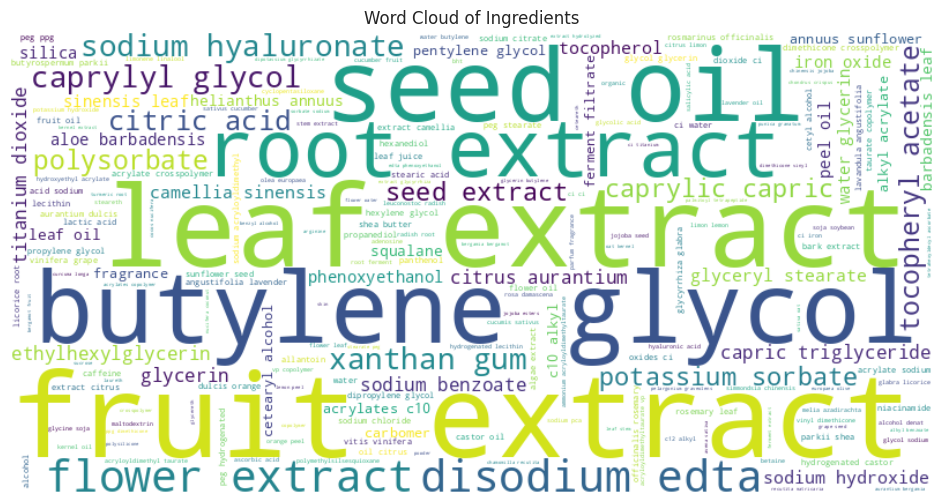

In [ ]:
all_ingredients = ' '.join(ingredients_text)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_ingredients)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Ingredients')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42)
tsne_df['Cluster'] = kmeans.fit_predict(X_scaled)

fig = px.scatter(tsne_df, x='X', y='Y', color='Cluster', hover_data=['Name', 'Brand', 'Price', 'Rank', 'Ingredients'],
                 title='Clustering Results - t-SNE Visualization',
                 labels={'X': 't-SNE 1', 'Y': 't-SNE 2'})

fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(X_scaled)

def get_similar_products(product_name, top_n=5):
    idx = filtered_df[filtered_df['Name'] == product_name].index[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    product_indices = [i[0] for i in sim_scores]
    similar_products = filtered_df.iloc[product_indices]

In [ ]:
from ipywidgets import Dropdown, HBox, VBox
import ipywidgets as widgets
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
tsne_df = pd.read_csv('/content/cosmetics.csv')

X = tsne_df[['Price', 'Rank']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

product_names = tsne_df['Name'].tolist()
product_dropdown = Dropdown(
    options=product_names,
    description='Product:',
    style={'description_width': 'initial'},
    layout={'width': 'initial'}
)

similarity_matrix = cosine_similarity(X_scaled)

filtered_df = tsne_df

def get_similar_products(product_name, top_n=5):
    idx = filtered_df[filtered_df['Name'] == product_name].index[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    product_indices = [i[0] for i in sim_scores]
    similar_products = filtered_df.iloc[product_indices]
    return similar_products

def display_similar_products(product_name):
    similar_products = get_similar_products(product_name)

    table = pd.DataFrame(similar_products[['Name', 'Brand', 'Price', 'Rank']])
    table.set_index('Name', inplace=True)

    display(table)

button = widgets.Button(description="Get Similar Products")

def on_button_click(b):
    product_name = product_dropdown.value
    display_similar_products(product_name)

button.on_click(on_button_click)

layout = VBox(children=[product_dropdown, button])

display(layout)

,Brand,Price,Rank
Name,,,
Umbra Tinte™ Physical Daily Defense Broad Spectrum Sunscreen SPF 30,DRUNK ELEPHANT,36,3.6
No Puffery™ Cooling Roll-On For Puffy Eyes,ORIGINS,29,3.4
BB Eye Cream with Soothing Cornflower,KLORANE,26,3.3
Oil-Free Face Cream Broad Spectrum SPF 30,CLINIQUE,26,3.3
DayWear Eye Cooling Anti-Oxidant Moisture GelCreme,ESTÉE LAUDER,40,3.7
